# This implementation is based on the paper: A Neural Probabilistic Language Model by Bengio (2003)

In [142]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [37]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [38]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Build a dataset

Block size defines the context length, i.e. how many characters we take to predict the next one. e.g if we have block_size=3, we take 3 chars and predict the 4th char 

In [104]:
block_size = 3
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size # padded context starting with 0 tokens
    for ch in w + '.': # iterate over all characters
        ix = stoi[ch]
        X.append(context)
        Y.append(ix) 
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop the context and enter the new char in sequence. like a rolling window

X = torch.tensor(X)
Y = torch.tensor(Y)


In [105]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

 <img src='image.png'/>

We want to build the embedding lookup table C from our 26+1 possible chars, which we will embed in a lower embedding space. In the paper, they cram 17,000 words in an embedding space of size 30 

In [41]:
C = torch.randn((27, 2)) # 2 dim embedding

Let's embed a single individual for illustration e.g. 5 position

This becomes essentially the 5th element of C

In [42]:
C[5]

tensor([-1.1034,  0.8108])

Embedding the entire X

In [43]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [44]:
# The 13th index of our X is
X[13,2]

# and its embedding is
C[X][13,2]

tensor([-0.8793,  1.9643])

# Constructing the hidden layer. 

The number of inputs is 3x2=6 because we have 2 dimensional embeddings and 3 of them

In [55]:
W1 = torch.randn((6, 100))  # arbitrary 100 neurons
b1 = torch.randn(100)

Since we have emb shape (32, 3, 2), we can't multiply by (6, 100). We need emb as (32, 6) by concatenating

In [46]:
# We extract everything in the 0th, 1st, and 2nd dimensions
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

The code above is manually specified for 3 words block_size. If we want it to be flexible for all dims of emb, we automatically unbind it to its number of dims

In [48]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.3660, -0.6685, -0.3660, -0.6685, -0.3660, -0.6685],
        [-0.3660, -0.6685, -0.3660, -0.6685, -1.1034,  0.8108],
        [-0.3660, -0.6685, -1.1034,  0.8108, -0.5937,  0.1702],
        [-1.1034,  0.8108, -0.5937,  0.1702, -0.5937,  0.1702],
        [-0.5937,  0.1702, -0.5937,  0.1702, -0.8793,  1.9643],
        [-0.3660, -0.6685, -0.3660, -0.6685, -0.3660, -0.6685],
        [-0.3660, -0.6685, -0.3660, -0.6685,  0.7955, -0.2615],
        [-0.3660, -0.6685,  0.7955, -0.2615,  0.5661,  2.1205],
        [ 0.7955, -0.2615,  0.5661,  2.1205, -1.2556, -1.2444],
        [ 0.5661,  2.1205, -1.2556, -1.2444, -1.4407,  0.7613],
        [-1.2556, -1.2444, -1.4407,  0.7613, -1.2556, -1.2444],
        [-1.4407,  0.7613, -1.2556, -1.2444, -0.8793,  1.9643],
        [-0.3660, -0.6685, -0.3660, -0.6685, -0.3660, -0.6685],
        [-0.3660, -0.6685, -0.3660, -0.6685, -0.8793,  1.9643],
        [-0.3660, -0.6685, -0.8793,  1.9643, -1.4407,  0.7613],
        [-0.8793,  1.9643, -1.4407,  0.7

A more efficient way to do this. Consider an example below

In [50]:
a = torch.arange(18)

In [52]:
# we can look at 'a' as a combination of different smaller arrays such as 
a.view(9, 2)
a.view(3, 3, 2)
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

... back to emb

emb is initially a (32, 3, 2). We can directly flatten it by viewing

In [54]:
emb.view(32, 6)

# verifying
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

and our activation becomes

In [67]:
h = emb.view(32, 6) @ W1 + b1
# To prevent hardcoding, we can
h = emb.view(emb.shape[0], 6) @ W1 + b1
# or
h = emb.view(-1, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [66]:
h = torch.tanh(h)
h

tensor([[ 0.9441, -0.5456,  0.8168,  ..., -0.9750, -0.5604,  0.1397],
        [ 0.9998, -0.9996,  0.6516,  ..., -0.9356,  0.9998,  0.6303],
        [ 0.9997, -0.1669, -0.9755,  ..., -0.9765,  0.9941,  0.5519],
        ...,
        [ 0.9978,  0.9881, -0.7742,  ..., -0.1810, -0.6170, -0.3562],
        [ 0.9929,  0.7236,  0.9950,  ..., -0.5910,  0.0550, -0.9935],
        [ 0.9989, -1.0000,  0.6721,  ..., -0.9989,  1.0000,  0.8848]])

# Final Layer

In [69]:
W2 = torch.randn((100, 27))  # 100 input from prev layer, 27 output possible chars
b2 = torch.randn(27)

In [70]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

we want the probabilities of the logits

In [85]:
counts = logits.exp() # converts them to positive
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

Now predicting the letter that comes next. We'd like to index into the rows of prob and from each row get the prob assigned to the correct char

In [84]:
prob[torch.arange(32), Y] 
# then the loss
loss = -prob[torch.arange(32), Y].log().mean() 
loss

tensor(17.7697)

This method of calculating loss is essentially crossentropy loss

In [88]:
F.cross_entropy(logits, Y)

tensor(17.7697)

F.cross_entropy is more efficient than doing this manually because of the tensors created by the current implementation. PyTorch creates fused kernels to calculate. It also automatically normalizes the logits to prevent NaN

# Summarizing everything

In [106]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [146]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # make params neat
for p in parameters:
    p.requires_grad = True

In [109]:
for _ in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
# print(loss.item())

10.709587097167969
10.407631874084473
10.127808570861816
9.864364624023438
9.614501953125
9.376439094543457
9.148944854736328
8.931110382080078
8.722230911254883
8.521749496459961
8.329227447509766
8.144325256347656
7.966791152954102
7.796450614929199
7.633184909820557
7.476907730102539
7.327521800994873


KeyboardInterrupt: 

We are not able to reach a near zero loss because the '...' of the input chars predict several different chars. Go to the beginning of the code and pass for the entire dataset

Currently, for the entire dataset, the training is slow. Use minibatches of data to improve training

In [114]:
torch.randint(0, X.shape[0], (32,))  # generate random ints between 0 and 'len(X)', minibatch of 32

tensor([214909, 214766, 178300, 228082,  42135, 206173,  60195,   2044,  67303,
        154620, 119278,  83359,   1362,   6010,  64812, 115142,  86969, 125061,
          2497,  25026, 163756,  99828,  68867, 227439,  74628,  69588,  86539,
        169331, 164560,  84847, 171529, 216903])

In [124]:
for _ in range(1000):
    # minibatching
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]] # only grab elements with indices ix

    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.4027316570281982


With minibatches, the quality of grad descent is based on the grad of the mini-batch (kind of local minimum), but it is good enough. It is better to get several local minima over multiple steps than to get a global minimum in a few steps. Compare the stepwise minimum obtained from batching against that from the entire dataset

In [125]:
emb = C[X] # only grab elements with indices ix
# forward pass
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.5459659099578857

We want to find a reasonable learning rate (not by random guessing)

In [126]:
lre = torch.linspace(-3, 0, 1000)  # exponents
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [132]:
lri = []
loss_i = []
for i in range(1000):
    # minibatching
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]] # only grab elements with indices ix

    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track
    lri.append(lre[i]) # we want the actual lr value
    loss_i.append(loss.item())
print(loss.item())

5.964555740356445


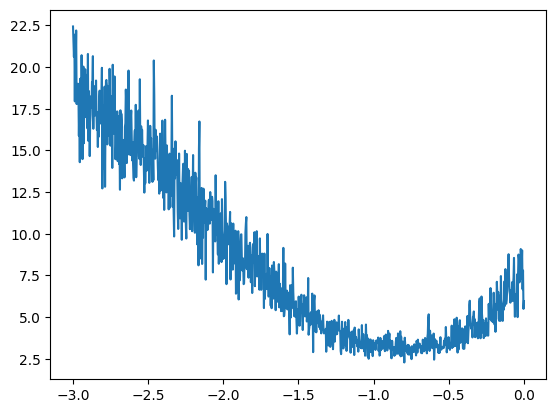

In [133]:
plt.plot(lri, loss_i)
plt.show()

We can see that -1 was a really good learning rate. So we can set our lr = -1

In [141]:
for i in range(10000):
    # minibatching
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]] # only grab elements with indices ix

    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.4504339694976807


# Train Val Test

Train set to optimize model params, val for hyperparams, test to val the model at the end

In [143]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)            
    print(X.shape, Y.shape)
    return X, Y

random.seed(24)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182537, 3]) torch.Size([182537])
torch.Size([22796, 3]) torch.Size([22796])
torch.Size([22813, 3]) torch.Size([22813])


In [147]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # make params neat
for p in parameters:
    p.requires_grad = True

In [150]:
for i in range(10000):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]] # only grab elements with indices ix

    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.25858736038208


Eval

In [152]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.396326780319214

In [153]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.40276837348938

# Increasing model size

Train and val loss are pretty similar, so we are underfitting. We need to increase the size of the model

In [159]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # make params neat
for p in parameters:
    p.requires_grad = True

In [175]:
lri = []
loss_i = []
stepi = []

for i in range(30000):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]] # only grab elements with indices ix

    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    loss_i.append(loss.item())

print(loss.item())

2.2663371562957764


In [173]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.3631186485290527

In [174]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.377322196960449

# Improving the Embedding Layer

Our loss is still fairly high indicating that increasing the inner layer doesn't improve the training that much. It shows a possible bottleneck at the embedding layer. i.e. we could be cramming way too many chars into a smaller space

Let's visualize the embeddings that were trained by the neural nets

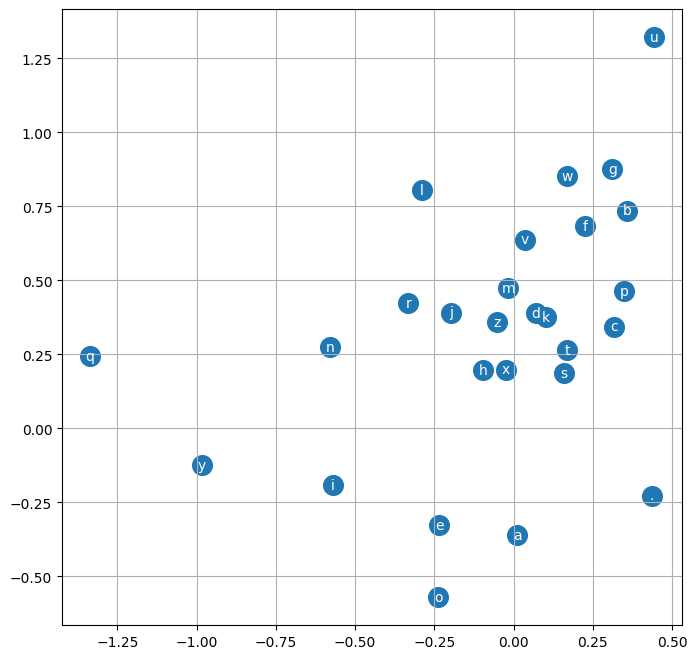

In [179]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')
plt.show()

The network has learned to cluster chars in different spaces. e.g. vowels (i, e, a, o) are in the similar space. q and u are in far positions. 

Let's modify the embedding layer

In [188]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)  # 10 dimensional embeddings for each word
W1 = torch.randn((30, 200), generator=g)  # 3x10 inputs
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # make params neat
for p in parameters:
    p.requires_grad = True

In [189]:
lri = []
loss_i = []
stepi = []

In [194]:
for i in range(30000):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]

    # forward pass
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # Modified here from 6 to 30
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    loss_i.append(loss.log10().item())

print(loss.item())

2.355476140975952


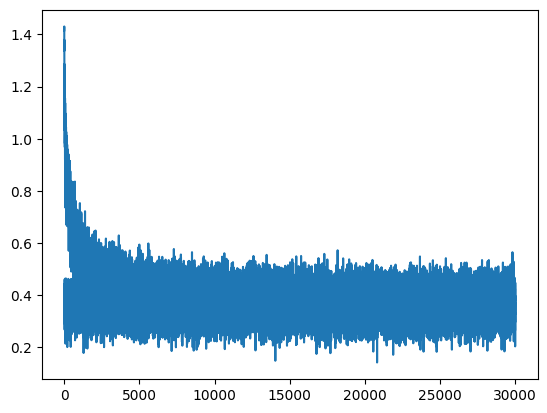

In [195]:
plt.plot(stepi, loss_i)
plt.show()

In [196]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.224147081375122

In [197]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.257059097290039

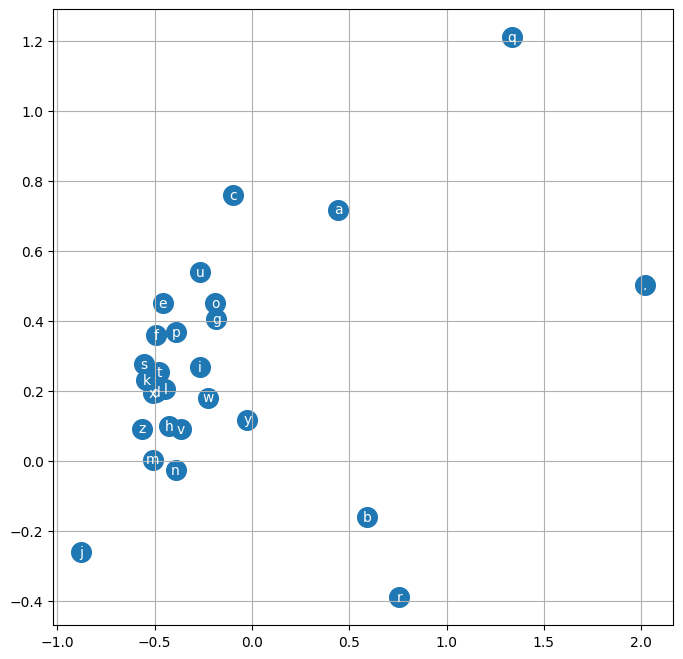

In [198]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')
plt.show()

In production, you run the hyperparams variations as experiments to find the best setup. Then you take that model and run on the test set

# Sampling the Model

In [199]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mona.
kayah.
seel.
ndhry.
larethrshekgon.
gradered.
elin.
shy.
jen.
edenson.
anaraelyzion.
karin.
shorvigahiries.
kin.
retel.
panteron.
uberthe.
ruyah.
faeh.
yuma.
